In [318]:
data_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks"

IO_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO"
# 0 to 19 trailel
VR_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VR"
# 0 to 12 trailel
VV_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-VV"
# 0 to 12 trailel

Data_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO/S00_data.csv"
Labels_path = "/content/drive/MyDrive/ML_Datasets/EEG-EyeBlinks-public/EEG-EyeBlinks/EEG-IO/S00_labels.csv"


In [319]:
# ==============================
# 📚 جميع المكتبات المطلوبة
# ==============================

# التعامل مع الملفات والبيانات
import os               # للتعامل مع الملفات والمجلدات
import csv              # قراءة ملفات CSV
import numpy as np      # المصفوفات وعمليات الحساب
import random           # توليد نوافذ عشوائية أو shuffle

# معالجة الإشارات (Signal Processing)
from scipy.signal import butter, lfilter   # تطبيق فلتر Low-pass / High-pass

# بناء الشبكات العصبية (Deep Learning)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# تقييم الأداء وVisualization
import matplotlib.pyplot as plt                      # رسم الإشارات والنتائج
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# تحسين وتحميل البيانات
from sklearn.utils import shuffle                    # لخلط البيانات قبل التدريب

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [320]:
def decode_stim(data_path, file_stim):
    interval_corrupt = []
    blinks = []
    n_corrupt = 0
    with open(os.path.join(data_path,file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0]=="corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                if float(row[1]) == -1:
                    t_end = data_sig[-1,0]
                else:
                    t_end = float(row[1])
                interval_corrupt.append([float(row[0]), t_end])
                n_corrupt = n_corrupt - 1
            elif row[0]=="blinks":
                #check that n_corrupt is 0
                if not n_corrupt==0:
                    print ("!Error in parsing")
            else:
                blinks.append([float(row[0]), int(row[1])])
    blinks = np.array(blinks)

    return interval_corrupt, blinks

In [321]:
import os
import numpy as np

fs = 250.0  # Sampling frequency

def load_full_dataset(folder_path):
    """
    Reads all *_data.csv and *_labels.csv files in the folder
    Supports EEG-IO, EEG-MB, EEG-VR, EEG-VV
    Returns:
        all_data: list of numpy arrays (each subject's data)
        all_blinks: list of lists (blink labels per subject)
        all_intervals: list of intervals per subject
        all_subject_names: list of subject names
    """

    data_files = sorted([f for f in os.listdir(folder_path) if '_data' in f])

    all_data = []
    all_blinks = []
    all_intervals = []
    all_subject_names = []

    for data_file in data_files:
        label_file = data_file.replace('_data', '_labels')
        data_path = os.path.join(folder_path, data_file)

        print(f"\nProcessing: {data_file}")

        # ----- Load data according to dataset type -----
        if folder_path.endswith('EEG-IO') or folder_path.endswith('EEG-MB'):
            data_sig = np.loadtxt(data_path, delimiter=";", skiprows=1, usecols=(0,1,2))
        elif folder_path.endswith('EEG-VR') or folder_path.endswith('EEG-VV'):
            data_sig = np.loadtxt(data_path, delimiter=",", skiprows=5, usecols=(0,1,2))
            data_sig = data_sig[0:(int(200*fs)+1), :]
            data_sig = data_sig[:, 0:3]
            data_sig[:,0] = np.arange(0, len(data_sig)) / fs
        else:
            raise ValueError("Unknown dataset folder. Supported: EEG-IO, EEG-MB, EEG-VR, EEG-VV")

        # ----- Load labels -----
        intervals, blinks = decode_stim(folder_path, label_file)

        # ----- Store -----
        all_data.append(data_sig)
        all_blinks.append(blinks)
        all_intervals.append(intervals)
        all_subject_names.append(data_file.replace("_data.csv",""))

        print(f"  - Data shape: {data_sig.shape}")
        print(f"  - Blinks: {len(blinks)}")
        print(f"  - Corrupt intervals: {len(intervals)}")

    print("\nFinished loading all dataset!")
    return all_data, all_blinks, all_intervals, all_subject_names


In [322]:
IO_all_data, IO_all_blinks, IO_all_intervals, IO_all_subject_names = load_full_dataset(IO_path)


Processing: S00_data.csv
  - Data shape: (25568, 3)
  - Blinks: 25
  - Corrupt intervals: 1

Processing: S01_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S02_data.csv
  - Data shape: (25568, 3)
  - Blinks: 25
  - Corrupt intervals: 0

Processing: S03_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 1

Processing: S04_data.csv
  - Data shape: (25536, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S05_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S06_data.csv
  - Data shape: (19328, 3)
  - Blinks: 27
  - Corrupt intervals: 0

Processing: S07_data.csv
  - Data shape: (25696, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S08_data.csv
  - Data shape: (25664, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S09_data.csv
  - Data shape: (25696, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S10_data.csv
  - Data shape: (25664, 3)
  - Blinks: 25
  

In [323]:
VR_all_data, VR_all_blinks, VR_all_intervals, VR_all_subject_names = load_full_dataset(VR_path)


Processing: S00R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 61
  - Corrupt intervals: 0

Processing: S01R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 29
  - Corrupt intervals: 1

Processing: S02R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S03R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 96
  - Corrupt intervals: 1

Processing: S04R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 101
  - Corrupt intervals: 6

Processing: S05R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 27
  - Corrupt intervals: 3

Processing: S06R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 16
  - Corrupt intervals: 0

Processing: S07R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 111
  - Corrupt intervals: 2

Processing: S08R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 49
  - Corrupt intervals: 2

Processing: S09R_data.csv
  - Data shape: (50001, 3)
  - Blinks: 11
  - Corrupt intervals: 0

Processing: S10R_data.csv
  - Data shape: (50001, 3)
  - 

In [324]:
VV_all_data, VV_all_blinks, VV_all_intervals, VV_all_subject_names = load_full_dataset(VV_path)


Processing: S00V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 66
  - Corrupt intervals: 0

Processing: S01V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 16
  - Corrupt intervals: 0

Processing: S02V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 36
  - Corrupt intervals: 1

Processing: S03V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 74
  - Corrupt intervals: 2

Processing: S04V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 102
  - Corrupt intervals: 2

Processing: S05V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 42
  - Corrupt intervals: 1

Processing: S06V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 16
  - Corrupt intervals: 0

Processing: S07V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 132
  - Corrupt intervals: 1

Processing: S08V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 71
  - Corrupt intervals: 1

Processing: S09V_data.csv
  - Data shape: (50001, 3)
  - Blinks: 43
  - Corrupt intervals: 1

Processing: S10V_data.csv
  - Data shape: (50001, 3)
  - 

In [325]:
# Positive: Startle Blinks (code=1)
positive_blinks = []

for i, blinks in enumerate(IO_all_blinks):
    startle_idx = np.where(blinks[:,1] == 1)[0]
    positive_blinks.extend([ (i, idx) for idx in startle_idx ])


In [326]:
import random

def get_safe_negative_windows(data, blinks, n_windows, fs=250, window_size=250, min_distance_sec=2.0):
    """
    اختيار نوافذ negative بعيدة عن أي blink

    Parameters:
    -----------
    data: numpy array - بيانات EEG
    blinks: numpy array - أوقات الـ blinks [time, code]
    n_windows: int - عدد النوافذ المطلوبة
    fs: float - sampling frequency (250 Hz)
    window_size: int - حجم النافذة (250 samples = 1 sec)
    min_distance_sec: float - المسافة الآمنة من أي blink (بالثواني)

    Returns:
    --------
    list of safe window indices
    """
    safe_windows = []
    blink_times = blinks[:, 0]  # أوقات كل الـ blinks بالثواني
    min_distance_samples = int(min_distance_sec * fs)

    max_idx = data.shape[0] - window_size
    attempts = 0
    max_attempts = n_windows * 50  # لو مالقيناش كفاية نوافذ

    while len(safe_windows) < n_windows and attempts < max_attempts:
        # اختيار index عشوائي
        idx = random.randint(0, max_idx)
        time_sec = idx / fs

        # التأكد إن النافذة بعيدة عن كل الـ blinks
        distances = np.abs(blink_times - time_sec)

        if np.min(distances) > min_distance_sec:
            if idx not in safe_windows:  # تجنب التكرار
                safe_windows.append(idx)

        attempts += 1

    if len(safe_windows) < n_windows:
        print(f"⚠️ Warning: Could only find {len(safe_windows)}/{n_windows} safe windows")

    return safe_windows

# استخدام الدالة الجديدة
negative_windows = []

for i, data in enumerate(IO_all_data):
    n_windows = len(IO_all_blinks[i])
    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=IO_all_blinks[i],
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=2.0  # 2 ثانية مسافة آمنة
    )
    negative_windows.extend([ (i, idx) for idx in safe_idx ])

print(f"✅ Total negative windows from IO: {len(negative_windows)}")

# 30% و 20% من blinks كود 0 و 2 من VR + VV
vr_neg = []
for i, blinks in enumerate(VR_all_blinks):
    neg_idx = np.where((blinks[:,1]==0) | (blinks[:,1]==2))[0]
    vr_neg.extend([ (i, idx) for idx in neg_idx ])

vv_neg = []
for i, blinks in enumerate(VV_all_blinks):
    neg_idx = np.where((blinks[:,1]==0) | (blinks[:,1]==2))[0]
    vv_neg.extend([ (i, idx) for idx in neg_idx ])


⚠️ Warning: Could only find 10/26 safe windows
⚠️ Warning: Could only find 21/26 safe windows
⚠️ Warning: Could only find 5/44 safe windows
✅ Total negative windows from IO: 498


In [327]:
import numpy as np

def create_dataset_from_indices(all_data, all_blinks, positive_indices, negative_indices, window_size=250):
    """
    all_data: list of arrays per subject (samples x channels)
    all_blinks: list of arrays per subject (blink_time, code)
    positive_indices: list of tuples (subject_idx, blink_idx)
    negative_indices: list of tuples (subject_idx, start_idx)
    """
    X = []
    y = []

    # Positive windows
    for subj_idx, blink_idx in positive_indices:
        data = all_data[subj_idx]
        blink_time = all_blinks[subj_idx][blink_idx, 0]  # time in sec
        start_sample = int(blink_time * fs) - window_size//2
        start_sample = max(0, start_sample)
        end_sample = start_sample + window_size
        if end_sample <= data.shape[0]:
            X.append(data[start_sample:end_sample, 1:])  # channels only
            y.append(1)

    # Negative windows
    for subj_idx, start_idx in negative_indices:
        data = all_data[subj_idx]
        end_idx = start_idx + window_size
        if end_idx <= data.shape[0]:
            X.append(data[start_idx:end_idx, 1:])
            y.append(0)

    return np.array(X), np.array(y)

# مثال للاستخدام
X_posneg, y_posneg = create_dataset_from_indices(
    all_data=IO_all_data + VR_all_data + VV_all_data,
    all_blinks=IO_all_blinks + VR_all_blinks + VV_all_blinks,
    positive_indices=positive_blinks,
    negative_indices=negative_windows + vr_neg + vv_neg,
    window_size=250  # 1 sec
)

print("Shape of X:", X_posneg.shape)
print("Shape of y:", y_posneg.shape)


Shape of X: (2447, 250, 2)
Shape of y: (2447,)


In [328]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_posneg, y_posneg, random_state=42)


In [329]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X_shuffled, y_shuffled, test_size=0.3, random_state=42, stratify=y_shuffled)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (1712, 250, 2)
Val shape: (367, 250, 2)
Test shape: (368, 250, 2)


In [330]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')


In [331]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [332]:
window_size = X_train.shape[1]  # 250 samples (1 sec)
n_channels = X_train.shape[2]   # 2 channels: Fp1, Fp2

inputs = Input(shape=(window_size, n_channels))
x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 250, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_38 (Conv1D)              │ (None, 250, 32)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 125, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_40 (Conv1D)              │ (None, 62, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │       254,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,441 (1.10 MB)

 Trainable params: 289,441 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

In [333]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)
]

from sklearn.utils.class_weight import compute_class_weight

# حساب الـ class weights تلقائياً
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# تحويلها لـ dictionary
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"📊 Class weights: {class_weight_dict}")
print(f"   - Class 0 (negative): {class_weights[0]:.2f}")
print(f"   - Class 1 (positive): {class_weights[1]:.2f}")


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)


📊 Class weights: {0: np.float64(0.6193921852387844), 1: np.float64(2.5939393939393938)}
   - Class 0 (negative): 0.62
   - Class 1 (positive): 2.59
Epoch 1/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.7392 - loss: 501.0823

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.7408 - loss: 488.6022 - val_accuracy: 0.8065 - val_loss: 0.6819
Epoch 2/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8011 - loss: 0.6784

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8014 - loss: 0.6782 - val_accuracy: 0.8065 - val_loss: 0.6663
Epoch 3/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8012 - loss: 0.6634

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8014 - loss: 0.6632 - val_accuracy: 0.8065 - val_loss: 0.6520
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8013 - loss: 0.6495

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8014 - loss: 0.6494 - val_accuracy: 0.8065 - val_loss: 0.6388
Epoch 5/30
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8010 - loss: 0.6370

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8014 - loss: 0.6367 - val_accuracy: 0.8065 - val_loss: 0.6265
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8013 - loss: 0.6250

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8014 - loss: 0.6249 - val_accuracy: 0.8065 - val_loss: 0.6152
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8013 - loss: 0.6141

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8014 - loss: 0.6140 - val_accuracy: 0.8065 - val_loss: 0.6046
Epoch 8/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8012 - loss: 0.6041

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.8014 - loss: 0.6039 - val_accuracy: 0.8065 - val_loss: 0.5949
Epoch 9/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8013 - loss: 0.5946

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8014 - loss: 0.5945 - val_accuracy: 0.8065 - val_loss: 0.5858
Epoch 10/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8013 - loss: 0.5860

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8014 - loss: 0.5859 - val_accuracy: 0.8065 - val_loss: 0.5775
Epoch 11/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8011 - loss: 0.5782

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8014 - loss: 0.5779 - val_accuracy: 0.8065 - val_loss: 0.5698
Epoch 12/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8012 - loss: 0.5707

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8014 - loss: 0.5706 - val_accuracy: 0.8065 - val_loss: 0.5626
Epoch 13/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8011 - loss: 0.5641

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8014 - loss: 0.5638 - val_accuracy: 0.8065 - val_loss: 0.5561
Epoch 14/30
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8010 - loss: 0.5580

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8014 - loss: 0.5576 - val_accuracy: 0.8065 - val_loss: 0.5501
Epoch 15/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8013 - loss: 0.5520

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8014 - loss: 0.5519 - val_accuracy: 0.8065 - val_loss: 0.5445
Epoch 16/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8011 - loss: 0.5469

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8014 - loss: 0.5466 - val_accuracy: 0.8065 - val_loss: 0.5394
Epoch 17/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8012 - loss: 0.5420

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8014 - loss: 0.5418 - val_accuracy: 0.8065 - val_loss: 0.5348
Epoch 18/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8012 - loss: 0.5376

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8014 - loss: 0.5374 - val_accuracy: 0.8065 - val_loss: 0.5305
Epoch 19/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8013 - loss: 0.5335

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8014 - loss: 0.5334 - val_accuracy: 0.8065 - val_loss: 0.5266
Epoch 20/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8011 - loss: 0.5301

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8014 - loss: 0.5298 - val_accuracy: 0.8065 - val_loss: 0.5230
Epoch 21/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8013 - loss: 0.5265

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8014 - loss: 0.5264 - val_accuracy: 0.8065 - val_loss: 0.5198
Epoch 22/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8013 - loss: 0.5235

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8014 - loss: 0.5234 - val_accuracy: 0.8065 - val_loss: 0.5168
Epoch 23/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8012 - loss: 0.5209

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8014 - loss: 0.5207 - val_accuracy: 0.8065 - val_loss: 0.5141
Epoch 24/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8013 - loss: 0.5183

54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.8014 - loss: 0.5182 - val_accuracy: 0.8065 - val_loss: 0.5117
Epoch 25/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8011 - loss: 0.5163

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8014 - loss: 0.5159 - val_accuracy: 0.8065 - val_loss: 0.5094
Epoch 26/30
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8010 - loss: 0.5144

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8014 - loss: 0.5139 - val_accuracy: 0.8065 - val_loss: 0.5074
Epoch 27/30
51/54 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8010 - loss: 0.5125

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8014 - loss: 0.5121 - val_accuracy: 0.8065 - val_loss: 0.5056
Epoch 28/30
52/54 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8011 - loss: 0.5108

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8014 - loss: 0.5104 - val_accuracy: 0.8065 - val_loss: 0.5040
Epoch 29/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8013 - loss: 0.5091

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8014 - loss: 0.5089 - val_accuracy: 0.8065 - val_loss: 0.5025
Epoch 30/30
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8012 - loss: 0.5079

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8014 - loss: 0.5076 - val_accuracy: 0.8065 - val_loss: 0.5012


In [334]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np


In [335]:
# الحصول على probabilities
y_pred_prob = model.predict(X_test)

# تحويل probabilities لـ 0 أو 1
threshold = 0.5
y_pred = (y_pred_prob >= threshold).astype(int)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [336]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-score: {f1*100:.2f}%")


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision: 0.00%
Recall: 0.00%
F1-score: 0.00%


In [337]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[297   0]
 [ 71   0]]


In [338]:
# الحصول على probabilities
y_pred_prob = model.predict(X_test)

# تجربة thresholds مختلفة
thresholds = np.arange(0.3, 0.8, 0.05)  # من 0.3 لـ 0.8
best_f1 = 0
best_thresh = 0.5
best_metrics = {}

print("\n🔍 Testing different thresholds:\n")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 50)

for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"{t:<12.2f} {precision*100:<12.2f} {recall*100:<12.2f} {f1*100:<12.2f}")

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
        best_metrics = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

print("\n" + "="*50)
print(f"✅ Best threshold: {best_thresh:.2f}")
print(f"   - Precision: {best_metrics['precision']*100:.2f}%")
print(f"   - Recall: {best_metrics['recall']*100:.2f}%")
print(f"   - F1-Score: {best_metrics['f1']*100:.2f}%")

# استخدام أفضل threshold
y_pred_best = (y_pred_prob >= best_thresh).astype(int)

# طباعة confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print(f"\n📊 Confusion Matrix (threshold={best_thresh:.2f}):")
print(cm)
print(f"\nTrue Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

🔍 Testing different thresholds:

Threshold    Precision    Recall       F1-Score    
--------------------------------------------------
0.30         0.00         0.00         0.00        
0.35         0.00         0.00         0.00        
0.40         0.00         0.00         0.00        
0.45         0.00         0.00         0.00        
0.50         0.00         0.00         0.00        
0.55         0.00         0.00         0.00        
0.60         0.00         0.00         0.00        
0.65         0.00         0.00         0.00        
0.70         0.00         0.00         0.00        
0.75         0.00         0.00         0.00        

✅ Best threshold: 0.50


KeyError: 'precision'

In [ ]:


# حساب الـ class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# استخدامها في التدريب
history = model.fit(
    X_train, y_train,
    class_weight=class_weight_dict,  # ← هنا
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks
)

In [ ]:
def get_safe_negative_windows(data, blinks, window_size=250, min_distance=250):
    """
    اختيار نوافذ negative بعيدة عن أي blink
    min_distance: المسافة الآمنة (بالـ samples) من أي blink
    """
    safe_windows = []
    blink_times = blinks[:, 0]  # أوقات كل ال blinks

    for i in range(0, data.shape[0] - window_size, window_size//2):
        # تحويل الـ index لوقت
        time_sec = i / fs

        # التأكد إن النافذة بعيدة عن كل ال blinks
        distances = np.abs(blink_times - time_sec)
        if np.min(distances) > (min_distance / fs):
            safe_windows.append(i)

    return safe_windows

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.mean((1-alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

# في الـ compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=focal_loss(gamma=2., alpha=0.75),  # ← Focal Loss
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

window_size = X_train.shape[1]  # 250 samples (1 sec)
n_channels = X_train.shape[2]   # 2 channels: Fp1, Fp2

inputs = Input(shape=(window_size, n_channels))

# Block 1
x = Conv1D(32, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Block 2
x = Conv1D(64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Block 3
x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Dense layers
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile with adjusted learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # قللت learning rate
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

model.summary()

In [ ]:
# # قبل الـ train_test_split، أضف:
# from imblearn.over_sampling import SMOTE

# print(f"📊 Before SMOTE - Class distribution:")
# print(f"   Class 0: {np.sum(y_shuffled==0)}")
# print(f"   Class 1: {np.sum(y_shuffled==1)}")

# # تطبيق SMOTE
# smote = SMOTE(random_state=42, k_neighbors=3)
# X_flat = X_shuffled.reshape(X_shuffled.shape[0], -1)
# X_resampled, y_resampled = smote.fit_resample(X_flat, y_shuffled)
# X_resampled = X_resampled.reshape(-1, 250, 2)

# print(f"\n✅ After SMOTE - Class distribution:")
# print(f"   Class 0: {np.sum(y_resampled==0)}")
# print(f"   Class 1: {np.sum(y_resampled==1)}")

# # الآن استخدم X_resampled و y_resampled بدل X_shuffled و y_shuffled
# X_train, X_temp, y_train, y_temp = train_test_split(
#     X_resampled, y_resampled,  # ← هنا
#     test_size=0.3,
#     random_state=42,
#     stratify=y_resampled  # ← وهنا
# )

------------------------------------------------

-------------------------------------------
# NEW

-------------------------

In [339]:
def decode_stim(data_path, file_stim):
    """
    قراءة ملف الـ labels واستخراج:
    - corrupt intervals (الفترات الفاسدة)
    - blinks (أوقات الرمشات)
    """
    interval_corrupt = []
    blinks = []
    n_corrupt = 0

    with open(os.path.join(data_path, file_stim)) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=',')
        for row in readCSV:
            if row[0] == "corrupt":
                n_corrupt = int(row[1])
            elif n_corrupt > 0:
                if float(row[1]) == -1:
                    t_end = -1  # until end
                else:
                    t_end = float(row[1])
                interval_corrupt.append([float(row[0]), t_end])
                n_corrupt = n_corrupt - 1
            elif row[0] == "blinks":
                # check that n_corrupt is 0
                if not n_corrupt == 0:
                    print("!Error in parsing")
            else:
                blinks.append([float(row[0]), int(row[1])])

    blinks = np.array(blinks)
    return interval_corrupt, blinks

In [340]:
fs = 250.0  # Sampling frequency

def load_full_dataset(folder_path):
    """
    Reads all *_data.csv and *_labels.csv files in the folder
    Supports EEG-IO, EEG-MB, EEG-VR, EEG-VV
    Returns:
        all_data: list of numpy arrays (each subject's data)
        all_blinks: list of lists (blink labels per subject)
        all_intervals: list of intervals per subject
        all_subject_names: list of subject names
    """

    data_files = sorted([f for f in os.listdir(folder_path) if '_data' in f])

    all_data = []
    all_blinks = []
    all_intervals = []
    all_subject_names = []

    for data_file in data_files:
        label_file = data_file.replace('_data', '_labels')
        data_path = os.path.join(folder_path, data_file)

        print(f"\nProcessing: {data_file}")

        # ----- Load data according to dataset type -----
        if folder_path.endswith('EEG-IO') or folder_path.endswith('EEG-MB'):
            data_sig = np.loadtxt(data_path, delimiter=";", skiprows=1, usecols=(0,1,2))
        elif folder_path.endswith('EEG-VR') or folder_path.endswith('EEG-VV'):
            data_sig = np.loadtxt(data_path, delimiter=",", skiprows=5, usecols=(0,1,2))
            data_sig = data_sig[0:(int(200*fs)+1), :]
            data_sig = data_sig[:, 0:3]
            data_sig[:,0] = np.arange(0, len(data_sig)) / fs
        else:
            raise ValueError("Unknown dataset folder. Supported: EEG-IO, EEG-MB, EEG-VR, EEG-VV")

        # ----- Load labels -----
        intervals, blinks = decode_stim(folder_path, label_file)

        # ----- Store -----
        all_data.append(data_sig)
        all_blinks.append(blinks)
        all_intervals.append(intervals)
        all_subject_names.append(data_file.replace("_data.csv",""))

        print(f"  - Data shape: {data_sig.shape}")
        print(f"  - Blinks: {len(blinks)}")
        print(f"  - Corrupt intervals: {len(intervals)}")

    print("\n✅ Finished loading all dataset!")
    return all_data, all_blinks, all_intervals, all_subject_names

In [341]:
print("="*60)
print("LOADING EEG-IO DATASET")
print("="*60)
IO_all_data, IO_all_blinks, IO_all_intervals, IO_all_subject_names = load_full_dataset(IO_path)

print("\n" + "="*60)
print("LOADING EEG-VR DATASET")
print("="*60)
VR_all_data, VR_all_blinks, VR_all_intervals, VR_all_subject_names = load_full_dataset(VR_path)

print("\n" + "="*60)
print("LOADING EEG-VV DATASET")
print("="*60)
VV_all_data, VV_all_blinks, VV_all_intervals, VV_all_subject_names = load_full_dataset(VV_path)

print("\n" + "="*60)
print("📊 DATASET SUMMARY")
print("="*60)
print(f"IO subjects: {len(IO_all_data)}")
print(f"VR subjects: {len(VR_all_data)}")
print(f"VV subjects: {len(VV_all_data)}")
print(f"Total subjects: {len(IO_all_data) + len(VR_all_data) + len(VV_all_data)}")

LOADING EEG-IO DATASET

Processing: S00_data.csv
  - Data shape: (25568, 3)
  - Blinks: 25
  - Corrupt intervals: 1

Processing: S01_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S02_data.csv
  - Data shape: (25568, 3)
  - Blinks: 25
  - Corrupt intervals: 0

Processing: S03_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 1

Processing: S04_data.csv
  - Data shape: (25536, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S05_data.csv
  - Data shape: (25568, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S06_data.csv
  - Data shape: (19328, 3)
  - Blinks: 27
  - Corrupt intervals: 0

Processing: S07_data.csv
  - Data shape: (25696, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S08_data.csv
  - Data shape: (25664, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S09_data.csv
  - Data shape: (25696, 3)
  - Blinks: 26
  - Corrupt intervals: 0

Processing: S10_data.csv
  - Data shape: (2566

In [342]:
# Positive: Startle Blinks (code=1) من IO فقط
positive_blinks = []

for i, blinks in enumerate(IO_all_blinks):
    startle_idx = np.where(blinks[:,1] == 1)[0]
    positive_blinks.extend([ (i, idx) for idx in startle_idx ])

print(f"✅ Total positive samples (startle blinks): {len(positive_blinks)}")

✅ Total positive samples (startle blinks): 472


In [343]:
def get_safe_negative_windows(data, blinks, n_windows, fs=250, window_size=250, min_distance_sec=0.8):
    """
    اختيار نوافذ negative بعيدة عن أي blink

    Parameters:
    -----------
    data: numpy array - بيانات EEG
    blinks: numpy array - أوقات الـ blinks [time, code]
    n_windows: int - عدد النوافذ المطلوبة
    fs: float - sampling frequency (250 Hz)
    window_size: int - حجم النافذة (250 samples = 1 sec)
    min_distance_sec: float - المسافة الآمنة من أي blink (بالثواني)

    Returns:
    --------
    list of safe window indices
    """
    safe_windows = []
    blink_times = blinks[:, 0]  # أوقات كل الـ blinks بالثواني

    max_idx = data.shape[0] - window_size
    attempts = 0
    max_attempts = n_windows * 100

    while len(safe_windows) < n_windows and attempts < max_attempts:
        # اختيار index عشوائي
        idx = random.randint(0, max_idx)
        time_sec = idx / fs

        # التأكد إن النافذة بعيدة عن كل الـ blinks
        distances = np.abs(blink_times - time_sec)

        if np.min(distances) > min_distance_sec:
            if idx not in safe_windows:  # تجنب التكرار
                safe_windows.append(idx)

        attempts += 1

    # لو لسه مش كفاية، نقلل المسافة تدريجياً
    if len(safe_windows) < n_windows:
        reduced_distance = min_distance_sec * 0.6  # نقلل لـ 60%

        while len(safe_windows) < n_windows and attempts < max_attempts * 2:
            idx = random.randint(0, max_idx)
            time_sec = idx / fs
            distances = np.abs(blink_times - time_sec)

            if np.min(distances) > reduced_distance:
                if idx not in safe_windows:
                    safe_windows.append(idx)

            attempts += 1

    return safe_windows

In [344]:
# Negative windows strategy:
# 1. نوافذ آمنة من IO
# 2. نوافذ آمنة من VR
# 3. نوافذ آمنة من VV

negative_windows = []

# ====== من IO ======
print("="*60)
print("🔍 Generating negative windows from IO...")
print("="*60)
for i, data in enumerate(IO_all_data):
    n_windows = len(IO_all_blinks[i]) // 2  # نصف العدد من IO
    print(f"Subject {IO_all_subject_names[i]}: ", end="")

    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=IO_all_blinks[i],
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=0.8
    )

    print(f"Found {len(safe_idx)}/{n_windows} windows")
    negative_windows.extend([ (i, idx) for idx in safe_idx ])

print(f"\n✅ From IO: {len(negative_windows)} windows")

# ====== من VR ======
print("\n" + "="*60)
print("🔍 Generating negative windows from VR...")
print("="*60)
vr_negative = []
for i, data in enumerate(VR_all_data):
    blinks = VR_all_blinks[i]
    n_windows = max(len(blinks) // 3, 5)  # على الأقل 5 نوافذ
    print(f"Subject {VR_all_subject_names[i]}: ", end="")

    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=blinks,
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=0.8
    )

    print(f"Found {len(safe_idx)}/{n_windows} windows")
    # الـ indices بتاعة VR (offset بعدد subjects من IO)
    vr_negative.extend([ (len(IO_all_data) + i, idx) for idx in safe_idx ])

print(f"\n✅ From VR: {len(vr_negative)} windows")

# ====== من VV ======
print("\n" + "="*60)
print("🔍 Generating negative windows from VV...")
print("="*60)
vv_negative = []
for i, data in enumerate(VV_all_data):
    blinks = VV_all_blinks[i]
    n_windows = max(len(blinks) // 3, 5)
    print(f"Subject {VV_all_subject_names[i]}: ", end="")

    safe_idx = get_safe_negative_windows(
        data=data,
        blinks=blinks,
        n_windows=n_windows,
        fs=250,
        window_size=250,
        min_distance_sec=0.8
    )

    print(f"Found {len(safe_idx)}/{n_windows} windows")
    # الـ indices بتاعة VV
    vv_negative.extend([ (len(IO_all_data) + len(VR_all_data) + i, idx) for idx in safe_idx ])

print(f"\n✅ From VV: {len(vv_negative)} windows")

# دمج كل الـ negative windows
all_negative_windows = negative_windows + vr_negative + vv_negative

print("\n" + "="*60)
print("📊 NEGATIVE SAMPLES SUMMARY")
print("="*60)
print(f"Total negative windows: {len(all_negative_windows)}")
print(f"   - From IO: {len(negative_windows)}")
print(f"   - From VR: {len(vr_negative)}")
print(f"   - From VV: {len(vv_negative)}")
print("="*60)

🔍 Generating negative windows from IO...
Subject S00: Found 12/12 windows
Subject S01: Found 13/13 windows
Subject S02: Found 12/12 windows
Subject S03: Found 13/13 windows
Subject S04: Found 13/13 windows
Subject S05: Found 13/13 windows
Subject S06: Found 13/13 windows
Subject S07: Found 13/13 windows
Subject S08: Found 13/13 windows
Subject S09: Found 13/13 windows
Subject S10: Found 12/12 windows
Subject S11: Found 13/13 windows
Subject S12: Found 12/12 windows
Subject S13: Found 22/22 windows
Subject S14: Found 22/22 windows
Subject S15: Found 14/14 windows
Subject S16: Found 15/15 windows
Subject S17: Found 13/13 windows
Subject S18: Found 12/12 windows
Subject S19: Found 11/11 windows

✅ From IO: 274 windows

🔍 Generating negative windows from VR...
Subject S00R: Found 20/20 windows
Subject S01R: Found 9/9 windows
Subject S02R: Found 8/8 windows
Subject S03R: Found 32/32 windows
Subject S04R: Found 33/33 windows
Subject S05R: Found 9/9 windows
Subject S06R: Found 5/5 windows
Sub

In [345]:
def create_dataset_from_indices(all_data, all_blinks, positive_indices, negative_indices, window_size=250, fs=250):
    """
    all_data: list of arrays per subject (samples x channels)
    all_blinks: list of arrays per subject (blink_time, code)
    positive_indices: list of tuples (subject_idx, blink_idx)
    negative_indices: list of tuples (subject_idx, start_idx)
    """
    X = []
    y = []

    print("\n🔨 Creating dataset...")
    print(f"Positive samples to process: {len(positive_indices)}")
    print(f"Negative samples to process: {len(negative_indices)}")

    # Positive windows
    for subj_idx, blink_idx in positive_indices:
        if subj_idx >= len(all_data):
            continue

        data = all_data[subj_idx]
        blink_time = all_blinks[subj_idx][blink_idx, 0]  # time in sec
        start_sample = int(blink_time * fs) - window_size//2
        start_sample = max(0, start_sample)
        end_sample = start_sample + window_size

        if end_sample <= data.shape[0]:
            X.append(data[start_sample:end_sample, 1:])  # channels only (Fp1, Fp2)
            y.append(1)

    # Negative windows
    for subj_idx, start_idx in negative_indices:
        if subj_idx >= len(all_data):
            continue

        data = all_data[subj_idx]
        end_idx = start_idx + window_size

        if end_idx <= data.shape[0]:
            X.append(data[start_idx:end_idx, 1:])
            y.append(0)

    X = np.array(X)
    y = np.array(y)

    print(f"\n✅ Final dataset created!")
    print(f"   Shape: {X.shape}")
    print(f"   Class 0 (negative): {np.sum(y==0)} ({np.sum(y==0)/len(y)*100:.1f}%)")
    print(f"   Class 1 (positive): {np.sum(y==1)} ({np.sum(y==1)/len(y)*100:.1f}%)")

    return X, y

In [346]:
# دمج كل الداتاسيتات
all_combined_data = IO_all_data + VR_all_data + VV_all_data
all_combined_blinks = IO_all_blinks + VR_all_blinks + VV_all_blinks

# إنشاء الداتاسيت
X_posneg, y_posneg = create_dataset_from_indices(
    all_data=all_combined_data,
    all_blinks=all_combined_blinks,
    positive_indices=positive_blinks,
    negative_indices=all_negative_windows,
    window_size=250,
    fs=250
)

print(f"\nDataset ready for training! 🚀")


🔨 Creating dataset...
Positive samples to process: 472
Negative samples to process: 760

✅ Final dataset created!
   Shape: (1232, 250, 2)
   Class 0 (negative): 760 (61.7%)
   Class 1 (positive): 472 (38.3%)

Dataset ready for training! 🚀


In [347]:
def augment_eeg_data(X, y, augmentation_factor=2):
    """
    Data augmentation للـ EEG signals
    - إضافة noise
    - Time shifting
    - Scaling
    """
    X_aug = []
    y_aug = []

    print(f"🔄 Augmenting data with factor {augmentation_factor}...")

    for i in range(len(X)):
        signal = X[i]
        label = y[i]

        # Original
        X_aug.append(signal)
        y_aug.append(label)

        # Augmentations (only for positive class)
        if label == 1:
            for _ in range(augmentation_factor - 1):
                aug_signal = signal.copy()

                # 1. Add small noise
                noise = np.random.normal(0, 0.05, signal.shape)
                aug_signal = aug_signal + noise

                # 2. Random scaling (95% to 105%)
                scale = np.random.uniform(0.95, 1.05)
                aug_signal = aug_signal * scale

                # 3. Small time shift (±5 samples)
                shift = np.random.randint(-5, 6)
                if shift > 0:
                    aug_signal = np.pad(aug_signal, ((shift, 0), (0, 0)), mode='edge')[:-shift]
                elif shift < 0:
                    aug_signal = np.pad(aug_signal, ((0, -shift), (0, 0)), mode='edge')[-shift:]

                X_aug.append(aug_signal)
                y_aug.append(label)

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)

    print(f"✅ Augmentation complete!")
    print(f"   Original: {len(X)} samples")
    print(f"   Augmented: {len(X_aug)} samples")
    print(f"   Class 0: {np.sum(y_aug==0)}, Class 1: {np.sum(y_aug==1)}")

    return X_aug, y_aug

# استخدمه بعد create_dataset وقبل shuffle
X_augmented, y_augmented = augment_eeg_data(X_posneg, y_posneg, augmentation_factor=2)

# ثم shuffle
X_shuffled, y_shuffled = shuffle(X_augmented, y_augmented, random_state=42)

🔄 Augmenting data with factor 2...
✅ Augmentation complete!
   Original: 1232 samples
   Augmented: 1704 samples
   Class 0: 760, Class 1: 944


In [348]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X_posneg, y_posneg, random_state=42)
print("✅ Data shuffled successfully!")

✅ Data shuffled successfully!


In [349]:
from sklearn.model_selection import train_test_split

# Split: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_shuffled, y_shuffled,
    test_size=0.3,
    random_state=42,
    stratify=y_shuffled
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("="*60)
print("📊 DATA SPLIT")
print("="*60)
print(f"Train shape: {X_train.shape} - Class 0: {np.sum(y_train==0)}, Class 1: {np.sum(y_train==1)}")
print(f"Val shape:   {X_val.shape} - Class 0: {np.sum(y_val==0)}, Class 1: {np.sum(y_val==1)}")
print(f"Test shape:  {X_test.shape} - Class 0: {np.sum(y_test==0)}, Class 1: {np.sum(y_test==1)}")
print("="*60)

📊 DATA SPLIT
Train shape: (862, 250, 2) - Class 0: 532, Class 1: 330
Val shape:   (185, 250, 2) - Class 0: 114, Class 1: 71
Test shape:  (185, 250, 2) - Class 0: 114, Class 1: 71


In [350]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

print("✅ Data converted to float32")

✅ Data converted to float32


In [351]:
from sklearn.utils.class_weight import compute_class_weight

# حساب الـ class weights تلقائياً
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# تحويلها لـ dictionary
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print("="*60)
print("⚖️ CLASS WEIGHTS")
print("="*60)
print(f"Class 0 (negative): {class_weights[0]:.3f}")
print(f"Class 1 (positive): {class_weights[1]:.3f}")
print("="*60)
print("These weights will help the model focus more on the minority class (positive)")

⚖️ CLASS WEIGHTS
Class 0 (negative): 0.810
Class 1 (positive): 1.306
These weights will help the model focus more on the minority class (positive)


In [352]:
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

window_size = X_train.shape[1]  # 250 samples (1 sec)
n_channels = X_train.shape[2]   # 2 channels: Fp1, Fp2

print("="*60)
print("🏗️ BUILDING MODEL")
print("="*60)

inputs = Input(shape=(window_size, n_channels))

# Block 1
x = Conv1D(32, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Block 2
x = Conv1D(64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Block 3
x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Dense layers
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Compile with adjusted learning rate and additional metrics
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("\n✅ Model built successfully!")
model.summary()

🏗️ BUILDING MODEL

✅ Model built successfully!


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 250, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 250, 32)        │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 125, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 125, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 62, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 62, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 31, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 3968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │       508,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,121 (2.11 MB)

 Trainable params: 552,417 (2.11 MB)

 Non-trainable params: 704 (2.75 KB)

In [353]:
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal Loss for handling class imbalance
    Focuses more on hard examples
    """
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)

        # Calculate focal loss
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        loss = -K.mean(
            alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1) +
            (1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0)
        )

        return loss

    return focal_loss_fixed

# في model.compile استخدم:
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=2.0, alpha=0.75),  # ← Focal Loss
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

In [354]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization

window_size = X_train.shape[1]
n_channels = X_train.shape[2]

print("="*60)
print("🏗️ BUILDING ENHANCED MODEL WITH ATTENTION")
print("="*60)

inputs = Input(shape=(window_size, n_channels))

# Block 1
x = Conv1D(32, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Block 2
x = Conv1D(64, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Block 3 with Attention
x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)

# Attention mechanism
attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
x = LayerNormalization()(x + attention_output)  # Residual connection

x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.3)(x)

# Dense layers
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.4)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("\n✅ Enhanced model with Attention built!")
model.summary()

🏗️ BUILDING ENHANCED MODEL WITH ATTENTION

✅ Enhanced model with Attention built!


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 250, 2)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 250, 32)   │        352 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 250, 32)   │        128 │ conv1d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_43    │ (None, 125, 32)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 125, 32)   │          0 │ max_pooling1d_43… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 125, 64)   │     10,304 │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 64)   │        256 │ conv1d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_44    │ (None, 62, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 62, 64)    │          0 │ max_pooling1d_44… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 62, 128)   │     24,704 │ dropout_36[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 128)   │        512 │ conv1d_46[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 62, 128)   │     66,048 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 62, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 62, 128)   │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_45    │ (None, 31, 128)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 31, 128)   │          0 │ max_pooling1d_45… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 3968)      │          0 │ dropout_38[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 128)       │    508,032 │ flatten_15[0][0]

 Total params: 619,425 (2.36 MB)

 Trainable params: 618,721 (2.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [355]:
# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_eeg_blink_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("="*60)
print("🚀 STARTING TRAINING")
print("="*60)

# Training
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weight_dict,  # ← Class weights here
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")

🚀 STARTING TRAINING
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5149 - loss: 1.5139 - precision: 0.4018 - recall: 0.3140
Epoch 1: val_loss improved from inf to 1.26735, saving model to best_eeg_blink_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.5150 - loss: 1.5125 - precision: 0.4006 - recall: 0.3156 - val_accuracy: 0.6162 - val_loss: 1.2674 - val_precision: 0.5000 - val_recall: 0.1972
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5890 - loss: 1.3397 - precision: 0.5120 - recall: 0.4907
Epoch 2: val_loss improved from 1.26735 to 1.14115, saving model to best_eeg_blink_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5886 - loss: 1.3391 - precision: 0.5099 - recall: 0.4912 - val_accuracy: 0.6703 - val_loss: 1.1412 - val_precision: 0.5833 - val_recall: 0.4930
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5429 - loss: 1.3608 - precision: 0.4592 - recall: 0.5382
Epoch 3: val_loss improved fro

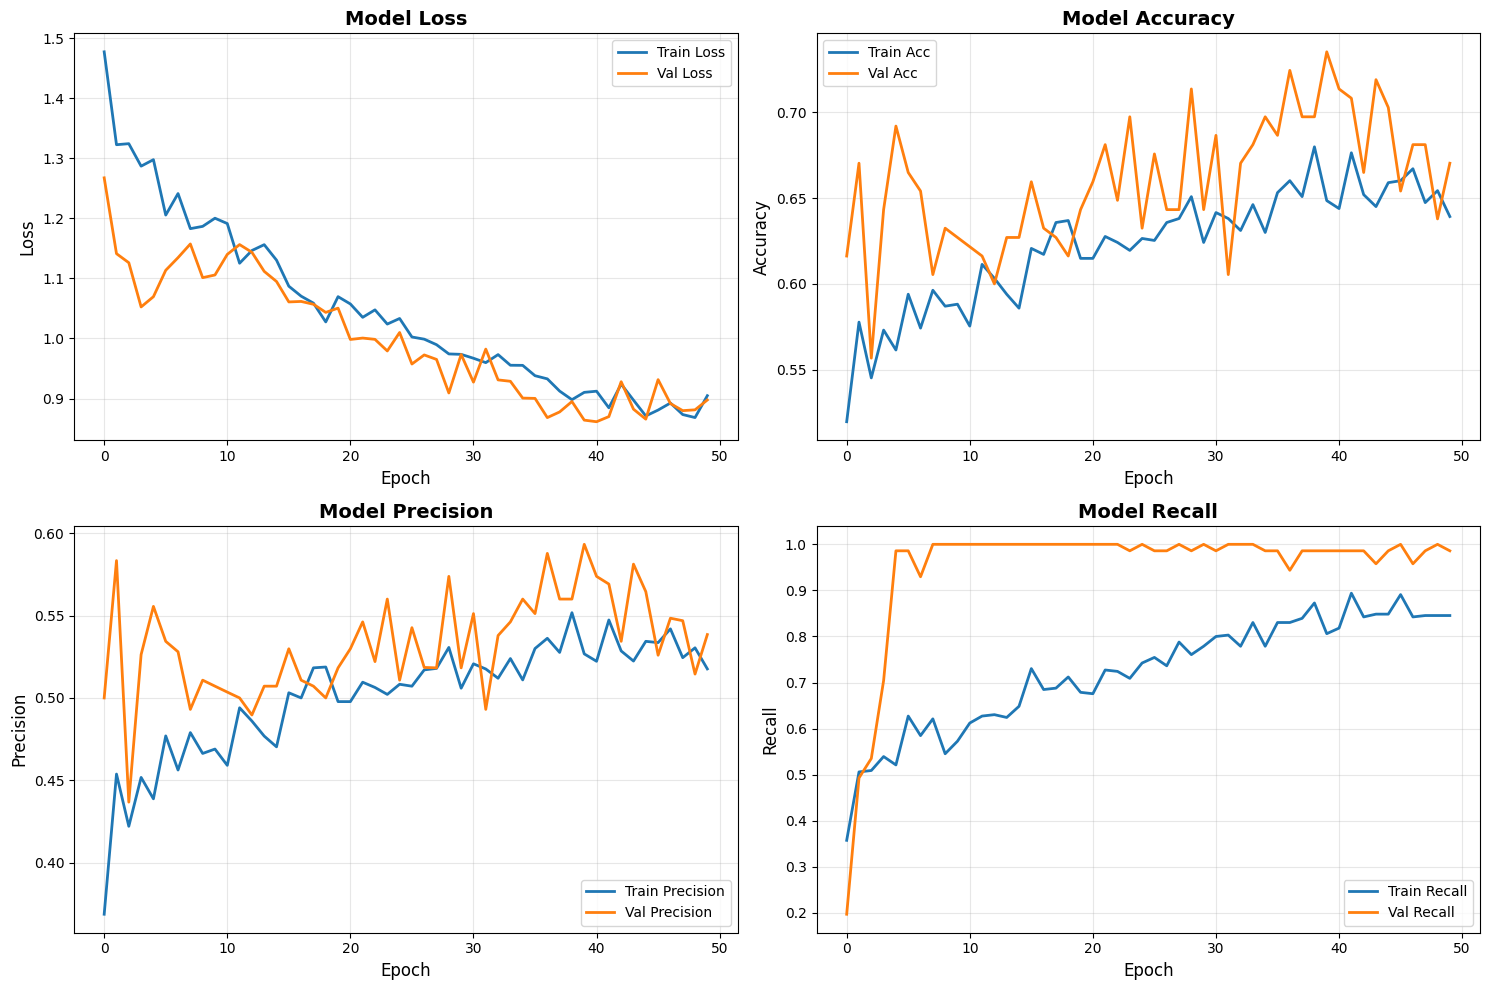

In [356]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Precision', fontsize=12)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Recall', fontsize=12)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [357]:
# الحصول على probabilities
y_pred_prob = model.predict(X_test)

# تجربة thresholds مختلفة
thresholds = np.arange(0.3, 0.8, 0.05)
best_f1 = 0
best_thresh = 0.5
best_metrics = {}

print("="*60)
print("🔍 TESTING DIFFERENT THRESHOLDS")
print("="*60)
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 50)

for t in thresholds:
    y_pred = (y_pred_prob >= t).astype(int)

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"{t:<12.2f} {precision*100:<12.2f} {recall*100:<12.2f} {f1*100:<12.2f}")

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
        best_metrics = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }

print("\n" + "="*60)
print("✅ BEST THRESHOLD RESULTS")
print("="*60)
print(f"Threshold: {best_thresh:.2f}")
print(f"Precision: {best_metrics['precision']*100:.2f}%")
print(f"Recall:    {best_metrics['recall']*100:.2f}%")
print(f"F1-Score:  {best_metrics['f1']*100:.2f}%")
print("="*60)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🔍 TESTING DIFFERENT THRESHOLDS
Threshold    Precision    Recall       F1-Score    
--------------------------------------------------
0.30         52.99        100.00       69.27       
0.35         53.49        97.18        69.00       
0.40         53.54        95.77        68.69       
0.45         54.84        95.77        69.74       
0.50         56.67        95.77        71.20       
0.55         57.29        77.46        65.87       
0.60         58.75        66.20        62.25       
0.65         55.56        42.25        48.00       
0.70         46.15        8.45         14.29       
0.75         16.67        1.41         2.60        

✅ BEST THRESHOLD RESULTS
Threshold: 0.50
Precision: 56.67%
Recall:    95.77%
F1-Score:  71.20%


In [358]:
# استخدام أفضل threshold
y_pred_best = (y_pred_prob >= best_thresh).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

print("\n" + "="*60)
print(f"📊 CONFUSION MATRIX (threshold={best_thresh:.2f})")
print("="*60)
print(cm)
print()
print(f"True Negatives  (TN): {cm[0,0]:>4} - Correctly predicted as No Blink")
print(f"False Positives (FP): {cm[0,1]:>4} - Incorrectly predicted as Blink")
print(f"False Negatives (FN): {cm[1,0]:>4} - Missed Blinks")
print(f"True Positives  (TP): {cm[1,1]:>4} - Correctly detected Blinks")
print("="*60)

# Classification report
print("\n" + "="*60)
print("📋 DETAILED CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_best, target_names=['No Blink', 'Blink']))


📊 CONFUSION MATRIX (threshold=0.50)
[[62 52]
 [ 3 68]]

True Negatives  (TN):   62 - Correctly predicted as No Blink
False Positives (FP):   52 - Incorrectly predicted as Blink
False Negatives (FN):    3 - Missed Blinks
True Positives  (TP):   68 - Correctly detected Blinks

📋 DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    No Blink       0.95      0.54      0.69       114
       Blink       0.57      0.96      0.71        71

    accuracy                           0.70       185
   macro avg       0.76      0.75      0.70       185
weighted avg       0.81      0.70      0.70       185



<Axes: >

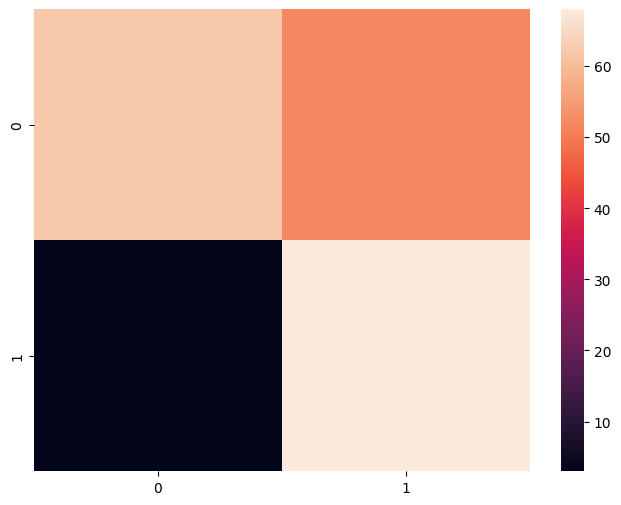

In [359]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm)

In [ ]:
# حفظ الموديل بالكامل
model.save("startle_blink_cnn_attention.h5")
print("✅ Model saved successfully as startle_blink_cnn_attention.h5")

In [ ]:
model.save("startle_blink_cnn_attention.keras")
